# Staples Sales Analytics Report 

### Jeffrey Fernandez

# Request 1: Q4 2024 Total Sales and Profit Prediction

## 1) Context:

Our initial focus is to address the first request:

R1: “Provide a prediction of total sales and total profit for the last quarter (Q4) of 2024, presented both overall and by category.”
- Select two regression techniques that are appropriate and interesting for this problem, explaining the rationale behind their selection.
- Train and evaluate two regression models, each utilizing one of the selected techniques.
- Perform a rigorous evaluation of both models to determine their strengths and weaknesses.
- Provide a detailed analysis and conclusions regarding the performance of each model, identifying which (if any) is preferable.

This process will allow us to develop reliable forecasts for Q4 2024, enabling the business to plan effectively across all categories. By leveraging our regression techniques, we aim to not only deliver accurate predictions but also gain valuable insights into the underlying trends and patterns driving sales and profitability. Our work begins by preparing and processing the dataset, after which we will analyze the results and evaluate the models' effectiveness through graphical and statistical comparisons.

## 2) Data Loading, Cleaning, and Initial Analytics

We will begin by loading in the data, cleaning it, and doing some initial analytics before diving into our predictive modelling.

### 2.1) Load the data

In [399]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import seaborn as sns

# Reading the CSV file Method 1 for Dates (note for x data is european so decimal is comma)
# Reading the CSV file Method 1 for Dates (note for x data is european so decimal is comma)
x = pd.read_csv('acme_2021_2022.csv', parse_dates = ['Order Date', 'Ship Date'], dayfirst = False, decimal = ',')
y = pd.read_json('acme_2023_2024.json', convert_dates = ['Order Date', 'Ship Date'])

# Convert 'order date' and 'ship date' columns to datetime objects
for col in ["Order Date", "Ship Date"]:
    x[col] = pd.to_datetime(x[col], format="%m/%d/%Y")
    y[col] = pd.to_datetime(y[col], format="%d/%m/%Y")

# Adding an additional column to our dataset for the order date year and month
x['Year'] = pd.DatetimeIndex(x['Order Date']).year
y['Year'] = pd.DatetimeIndex(y['Order Date']).year

x['Month'] = pd.DatetimeIndex(x['Order Date']).month
y['Month'] = pd.DatetimeIndex(y['Order Date']).month

# Combine the two datasets
df_total = pd.concat([x, y], ignore_index=True)

# Convert numerical columns to float or int
df_total['Sales'] = df_total['Sales'].astype(float)
df_total['Discount'] = df_total['Discount'].astype(float)
df_total['Profit'] = df_total['Profit'].astype(float)


df_total.describe()

,Postal Code,Region,Sales,Quantity,Discount,Profit,Year,Month
count,8304.000000,8304.000000,8304.000000,8304.000000,8304.000000,8304.000000,8304.000000,8304.000000
mean,55146.885838,1.516498,317.404111,3.789379,0.156348,48.485541,2022.467124,7.205323
std,31992.495076,1.205578,976.794175,2.216257,0.207122,1083.757640,1.058395,3.339783
min,1040.000000,0.000000,0.000000,1.000000,0.000000,-6619.780000,2021.000000,1.000000
25%,23223.000000,0.000000,22.792500,2.000000,0.000000,1.890000,2022.000000,4.000000
50%,57103.000000,1.000000,72.630000,3.000000,0.200000,9.545000,2023.000000,7.000000
75%,90004.000000,3.000000,289.112500,5.000000,0.200000,32.890000,2023.000000,10.000000
max,99301.000000,3.000000,43507.200000,14.000000,0.800000,91585.940000,2024.000000,12.000000


In [400]:
df_total.describe(include = 'object')

,Order ID,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Product ID,Category,Sub-Category,Product Name
count,8304,8304,8304,8304,8304,8304,8304,8304,8304,8304,8304,8304
unique,4142,4,789,782,3,1,500,49,1839,3,17,1827
top,2023-108504,Standard Class,WB-21850,William Peterson,Consumer,United States,New York City,California,OFF-PA-10001970,Office Supplies,Binders,Staple envelope
freq,11,5015,34,34,4323,8304,732,1671,17,5015,1273,43


Loaded above we are able to see a general distribution of our combined dataset from our last report. As a quick reminder, below is a breakdown of our variables of interest:

* **Order ID:** A unique identifier for each order.
* **Order Date:** The date when the order was placed.
* **Ship Date:** The date when the order was shipped.
* **Ship Mode:** The shipping method used (e.g., Standard Class).
* **Customer ID:** A unique identifier for each customer.
* **Customer Name:** The name of the customer
* **Segment:** The segment category of the customer (e.g., Consumer, Corporate).
* **Country:** The country where the order was placed.
* **City:** The city where the customer is located.
* **State:** The state where the customer is located.
* **Postal Code:** The postal code for the customer's location.
* **Region:** The region associated with the customer's location.
* **Product ID:** A unique identifier for the product.
* **Category:** The product category.
* **Sub-Category:** A more specific sub-category of the product.
* **Product Name:** The name of the product.
* **Sales:** The sales amount for the order.
* **Quantity:** The quantity of the product ordered.
* **Discount:** The discount applied to the order.
* **Profit:** The profit earned from the order.

Looking at our numerical descriptions, we can see some values for max sales and profit that appear irregular. To ensure the effectiveness of our model, we will quickly filter our any potential misinputs in our data set.

### 2.2) Cleaning the Data

1. An immidiate issue with our data table that can be addressed is an apparent max profit of 91,000, that greatly surpases our max sale of 43,507. To fix this, we will extract any values in which the profit exceeds the sale and remove them.

In [401]:
filter_df = df_total['Profit'] > df_total['Sales']

filtered_df = df_total[filter_df]

filtered_df

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Year,Month
3963,2022-126347,2022-12-15,2022-12-20,Second Class,AJ-10945,Ashley Romero,Consumer,United States,Los Angeles,California,...,TEC-AC-10003063,Technology,Accessories,Micro Innovations USB RF Wireless Keyboard wit...,61.00,2,0.0,69.30,2022,12
4245,2023-166674,2023-03-04,2023-05-04,Second Class,RB-19360,Raymond Cooper,Consumer,United States,Auburn,New York,...,TEC-PH-10002365,Technology,Phones,Belkin Grip Candy Sheer Case / Cover for iPhon...,53.73,4,0.0,91585.94,2023,3
6609,2023-108210,2023-01-06,2023-02-06,Same Day,AT-10735,Annie Butler,Consumer,United States,Houston,Texas,...,TEC-PH-10002293,Technology,Phones,Anker 36W 4-Port USB Wall Charger Travel Power...,0.00,5,0.2,8019.99,2023,1


In [402]:
# Remove row 3963, 4245, and 6609 since the profit exceeds sales and is inaccurate.
df_total = df_total.drop(3963, axis=0)
df_total = df_total.drop(4245, axis=0)
df_total = df_total.drop(6609, axis=0)

2. We will filter the data to remove any outliers in profit or sales that do not make logical sense. With the information gethered from our prior report, we will use profits below -6,000 and above 5,000 to benchmark any potential outliers.

In [403]:
# Search for any outliers by looking at a profit below -6000
df_outliers_below = df_total[df_total["Profit"]<-6000]
df_outliers_below

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Year,Month
6107,2023-108196,2023-11-27,2023-04-12,Standard Class,CS-12505,Cindy Hall,Consumer,United States,Lancaster,Ohio,...,TEC-MA-10000418,Technology,Machines,Cubify CubeX 3D Printer Double Head Print,6884.98,5,0.7,-6619.78,2023,11


Despite the large discount, profit is negative and sales is positive. So we will remove it.

In [404]:
df_total = df_total.drop(6107, axis=0)

Next, search for any outliers by looking at a profit above 5000.

In [405]:
df_outliers_above = df_total[df_total["Profit"]>5000]
df_outliers_above

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Year,Month
5833,2023-118689,2023-04-10,2023-11-10,Standard Class,TC-20980,Tamara Lewis,Corporate,United States,Lafayette,Indiana,...,TEC-CO-10004722,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,26774.92,5,0.0,8425.18,2023,4
7995,2024-140151,2024-03-24,2024-03-26,First Class,RB-19360,Raymond Cooper,Consumer,United States,Seattle,Washington,...,TEC-CO-10004722,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,22399.94,4,0.0,6921.58,2024,3
8213,2024-151855,2024-05-28,2024-04-06,Standard Class,BW-11110,Bart Weaver,Corporate,United States,Greensboro,North Carolina,...,TEC-AC-10002380,Technology,Accessories,Sony 64GB Class 10 Micro SDHC R40 Memory Card,43507.20,3,0.2,27980.10,2024,5


While the copiers have high profits, it seems reasonable based on the sales value. However, the sales and profit figures for the memory card seems inaccurate, so let's remove that.

In [406]:
df_total = df_total.drop(8213, axis=0)

3. Check that there are no discounts that are greater than 100%.

In [407]:
df_total[df_total["Discount"]>=1]

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Year,Month


Since there are none, we do not need to delete anything.

### 2.3) Analyzing the data & finding patterns

With our data now updated in preperation for predictive modeling, we can move on to some time based visualization to see any initial observable patterns in sale metrics by weeks, months, and years. This will set the foundation of our expectations for what our predicitive model should output. 

#### 2.3.1) Week-Based Grouping Preparation

In [408]:
df_total['Order Date'] = pd.to_datetime(df_total['Order Date'])

df_total['Week']= df_total['Order Date'] - pd.to_timedelta(df_total['Order Date'].dt.dayofweek, unit = 'd')

#### 2.3.2) Time Series Decompisition

This code performs a seasonal decomposition of time series data, specifically focusing on monthly sales. Each of these components is then visualized in a 4x1 subplot format, with customized colors and legends to make it easier to interpret the underlying patterns in the data. This analysis helps identify trends, seasonality, and noise within the sales data over time.

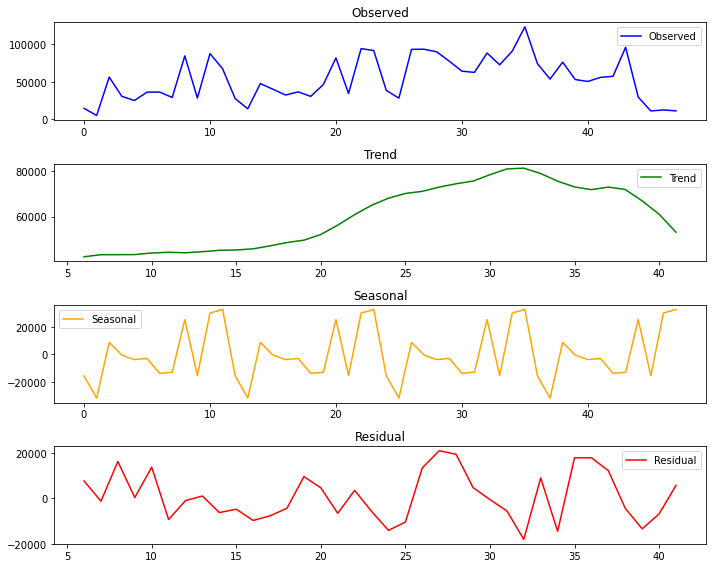

In [409]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose


df_monthly_sales = df_total.groupby([ 'Year', 'Month'])["Sales"].sum().reset_index()

# Assume df_monthly_sales['Sales'] and period = 12 are defined
result = seasonal_decompose(df_monthly_sales['Sales'], model="additive", period=12)

# Extract components
observed = result.observed
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Plot with custom colors
plt.figure(figsize=(10, 8))

# Plot for Observed
plt.subplot(4, 1, 1)
plt.plot(observed, color='blue', label='Observed')
plt.title('Observed')
plt.legend()

# Plot for Trend
plt.subplot(4, 1, 2)
plt.plot(trend, color='green', label='Trend')
plt.title('Trend')
plt.legend()

# Plot for Seasonal
plt.subplot(4, 1, 3)
plt.plot(seasonal, color='orange', label='Seasonal')
plt.title('Seasonal')
plt.legend()

# Plot for Residual
plt.subplot(4, 1, 4)
plt.plot(residual, color='red', label='Residual')
plt.title('Residual')
plt.legend()

plt.tight_layout()
plt.show()

Doing a deeper dive into the time series data and its components provides valuable insights into the sales dynamics:

- **Observed**: The observed graph reflects the raw sales data, highlighting fluctuations over time. There is clear variability seens through the highs and lows.

- **Trend**: The trend component captures the overall direction of sales. The graph indicates a steady increase in sales during the initial periods, followed by a gradual decline in later periods, which may suggest that there are changes in the market or consumer demand.

- **Seasonal**: The seasonal component identifies recurring patterns in sales on an annual basis. The graph reveals consistent cycles, likely influenced by factors such as holidays, promotional campaigns, or seasonality in customer demand.

- **Residual**: The residual component represents the irregular fluctuations that cannot be explained by the trend or seasonality. The variations seen here may require further investigation.

#### 2.3.3) Weekly Sales Trends Across Years

This visualization illustrates the total weekly sales trends across multiple years, enabling a comparison of sales performance over time. By grouping sales data by week and year, this chart highlights seasonal patterns, year-over-year fluctuations, and potential opportunities for further analysis.

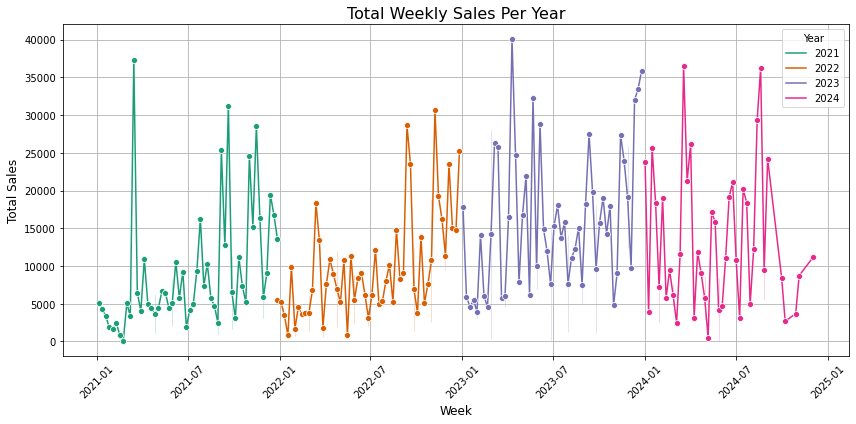

In [410]:
# Total Sales grouped 

weekly_data =  df_total.groupby([ 'Year', 'Month', 'Week'])["Sales"].sum().reset_index()


plt.figure(figsize=(12, 6))
sns.lineplot(data=weekly_data, x="Week", y="Sales", hue="Year", marker="o", palette = "Dark2")


plt.title("Total Weekly Sales Per Year", fontsize=16)
plt.xlabel("Week", fontsize=12)
plt.ylabel("Total Sales", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()


plt.show()

This visualization illustrates the total weekly sales trends across multiple years, enabling a comparison of sales performance over time. By grouping sales data by week and year, this chart highlights:

* **Seasonal Peaks and Trends**: Sales tend to spike at regular intervals each year, indicating possible seasonality. These peaks could correspond to holidays, promotional events, or specific periods of high demand.


* **Year-over-Year Growth**: There appears to be a general upward trend in sales across years, with higher peaks and more pronounced fluctuations in 2024 compared to earlier years.


* **Fluctuations in Weekly Sales**: Sales show significant weekly variability, suggesting that customer purchasing behavior may be influenced by external factors such as economic conditions, promotions, or product availability.

Our Chart also opens the door to potential opportunities for further analysis.

Now that we have done some initial analytics and looked at some trends, let's shift our focus towards the prective models for sales and profit during Q4 2024.

## 3) Regression Models & Evaluation:

When predicting total sales and profit for Q4 2024, we selected Linear Regression and Decision Tree models as our two regression techniques due to their complementary strengths. Linear Regression is effective for identifying overarching trends and producing consistent, straightforward forecasts, while Decision Tree models excel at capturing complex, non-linear relationships and local variations within the data. Using these two methods, we calculated the total sales and profit for Q4 across multiple categories, ensuring that the predictions are both comprehensive and insightful.

Within the accompanying code, we have included the detailed numerical results for those who wish to see exact values. However, the primary focus is on analyzing these projections visually through graphs, along with a write-up that evaluates the effectiveness of each model. Furthermore, we have rigorously compared the two models using two key metrics: Root Mean Squared Error (RMSE) and R-squared. RMSE measures the average magnitude of prediction errors, with lower values indicating better accuracy. R-squared, on the other hand, quantifies how well the model explains the variability of the data, with higher values reflecting stronger performance. These metrics provide a clear and objective assessment of each model's ability to forecast sales and profit accurately.

### 3.1) Model Creation and Evaluation

This code utilizes linear regression to analyze historical sales data aggregated by month and year. The approach involves preparing the data, splitting it into training and testing sets, and building predictive models to evaluate performance metrics like Root Mean Squared Error (RMSE) and R-squared.

In [432]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")


# Group sales by month and year - Excluding last quarter
monthly_metrics = df_total.groupby(['Year', 'Month'])['Sales','Profit'].sum().reset_index()
monthly_metrics = monthly_metrics.iloc[:-4]


# Prepare data for the model
# - Sales
X_sales = monthly_metrics[['Year', 'Month']].values
Y_sales = monthly_metrics['Sales'].values


# Split the data into training and testing sets for SALES, keeping order, 20% test size
x_train_sales, x_test_sales, y_train_sales, y_test_sales = train_test_split(X_sales, Y_sales, 
                                                                        test_size=0.2, 
                                                                        shuffle=True, 
                                                                        random_state=42)


# Train the linear regression model for sales
lr_model_sales = LinearRegression()
lr_model_sales.fit(x_train_sales, y_train_sales)

# Train the Decision tree model for sales
dt_model_sales = DecisionTreeRegressor()
dt_model_sales.fit(x_train_sales, y_train_sales)


# Make predictions for sales
lr_y_pred_sales = lr_model_sales.predict(x_test_sales)
dt_y_pred_sales = dt_model_sales.predict(x_test_sales)


# Evaluate the model
lr_rsme = np.sqrt(mean_squared_error(lr_y_pred_sales, y_test_sales))
dt_rsme = np.sqrt(mean_squared_error(dt_y_pred_sales, y_test_sales))

lr_r2 = r2_score(lr_y_pred_sales, y_test_sales)
dt_r2 = r2_score(dt_y_pred_sales, y_test_sales)

print(f"Linear Regression Root Mean Squared Error: {lr_rsme}")
print(f"Decision Tree Root Mean Squared Error: {dt_rsme}")

print(f"Linear Regression R-squared Score: {lr_r2}")
print(f"Decision Tree R-squared Score: {dt_r2}")



Linear Regression Root Mean Squared Error: 17453.434416919554
Decision Tree Root Mean Squared Error: 30425.62194225124
Linear Regression R-squared Score: 0.09573929145339555
Decision Tree R-squared Score: -0.37045185730855845


When analyzing the evaluation metrics reveal that the Linear Regression model achieved a lower Root Mean Squared Error (RMSE) of 17,453 compared to the Decision Tree’s RMSE of 30,425, indicating that the Linear Regression model provides more accurate and consistent predictions. Additionally, the R-squared score for Linear Regression is significantly higher than that of the Decision Tree, demonstrating its superior ability to explain the variance in the data. This makes sense from a statistical perspective, as the Linear Regression model is better suited for capturing time-based, linear relationships, whereas the Decision Tree model excels at handling non-linear patterns and categorical variables.

In [433]:
# Prepare data for the model
# - Profit
X_profit = monthly_metrics[['Year', 'Month']].values
Y_profit = monthly_metrics['Profit'].values



# Split the data into training and testing sets for PROFIT, keeping order, 20% test size
x_train_profit, x_test_profit, y_train_profit, y_test_profit = train_test_split(X_profit, Y_profit, 
                                                                                test_size=0.2, 
                                                                                shuffle=True, 
                                                                                random_state=42)


# Train the linear regression model for Profit
lr_model_profit = LinearRegression()
lr_model_profit.fit(x_train_profit, y_train_profit)

# Train the Decision tree model for Profit
dt_model_profit = DecisionTreeRegressor()
dt_model_profit.fit(x_train_profit, y_train_profit)


# Make predictions for sales
lr_y_pred_profit = lr_model_profit.predict(x_test_profit)

dt_y_pred_profit = dt_model_profit.predict(x_test_profit)


# Evaluate the model
lr_rsme = np.sqrt(mean_squared_error(lr_y_pred_profit, y_test_profit))
dt_rsme = np.sqrt(mean_squared_error(dt_y_pred_profit, y_test_profit))

lr_r2 = r2_score(lr_y_pred_profit, y_test_profit)
dt_r2 = r2_score(dt_y_pred_profit, y_test_profit)

print(f"Linear Regression Root Mean Squared Error: {lr_rsme}")
print(f"Decisioin Tree Root Mean Squared Error: {dt_rsme}")

print(f"Linear Regression R-squared Score: {lr_r2}")
print(f"Decision Tree R-squared Score: {dt_r2}")

Linear Regression Root Mean Squared Error: 3170.367776573918
Decisioin Tree Root Mean Squared Error: 4879.595827042327
Linear Regression R-squared Score: -3.1133955940755476
Decision Tree R-squared Score: -0.027456439758895446


The analysis reveals the performance of two models—Linear Regression and Decision Tree—trained on overall profit data. The Linear Regression model achieved a RMSE of 3,170, while the Decision Tree model's RMSE was 4,879, indicating that Linear Regression makes smaller overall errors on average. However, the negative R-squared values for Linear Regression and Decision Tree suggest that both models underperform relative to a simple baseline model, such as predicting the mean profit for all months.

### 3.2) Projected Sales and Profit using the Linear Regression Model

In [434]:
future_months = [[2024,9], [2024,10], [2024,11], [2024,12]]
future_sales = lr_model_sales.predict(future_months)
future_profit = lr_model_profit.predict(future_months)

lr_proj = pd.DataFrame({
    'Year': [2024,2024,2024,2024],
    'Month': [9,10,11,12],
    'Sales': future_sales,
    'Profit': future_profit  
    
})

lr_proj['Date'] = pd.to_datetime(lr_sales_proj[['Year', 'Month']].assign(DAY=1))
lr_proj['Date_Ordinal'] = lr_sales_proj['Date'].map(lambda x: x.toordinal())

print("Projection of the Sales and Profit for the Next 4 Months with Linear Regression")

lr_proj

Projection of the Sales and Profit for the Next 4 Months with Linear Regression


,Year,Month,Sales,Profit,Date,Date_Ordinal
0,2024,9,94681.981340,9519.929044,2024-09-01,739130
1,2024,10,99107.286555,9951.037379,2024-10-01,739160
2,2024,11,103532.591769,10382.145714,2024-11-01,739191
3,2024,12,107957.896984,10813.254048,2024-12-01,739221


### 3.3) Projected Sales and Profit using the Decision Tree Model

In [435]:
future_months = [[2024,9], [2024,10], [2024,11], [2024,12]]
future_sales = dt_model_sales.predict(future_months)
future_profit = dt_model_profit.predict(future_months)

dt_proj = pd.DataFrame({
    'Year': [2024,2024,2024,2024],
    'Month': [9,10,11,12],
    'Sales': future_sales,
    'Profit': future_profit
})

dt_proj['Date'] = pd.to_datetime(dt_proj[['Year', 'Month']].assign(DAY=1))
dt_proj['Date_Ordinal'] = dt_proj['Date'].map(lambda x: x.toordinal())

print("Projection of the Decision Tree Sales for the Next 4 Months with Linear Regression")

dt_proj

Projection of the Decision Tree Sales for the Next 4 Months with Linear Regression


,Year,Month,Sales,Profit,Date,Date_Ordinal
0,2024,9,96171.43,8056.55,2024-09-01,739130
1,2024,10,96171.43,8056.55,2024-10-01,739160
2,2024,11,96171.43,18245.83,2024-11-01,739191
3,2024,12,123533.85,12248.34,2024-12-01,739221


### 3.4) Visualizing Monthly Sales Projections

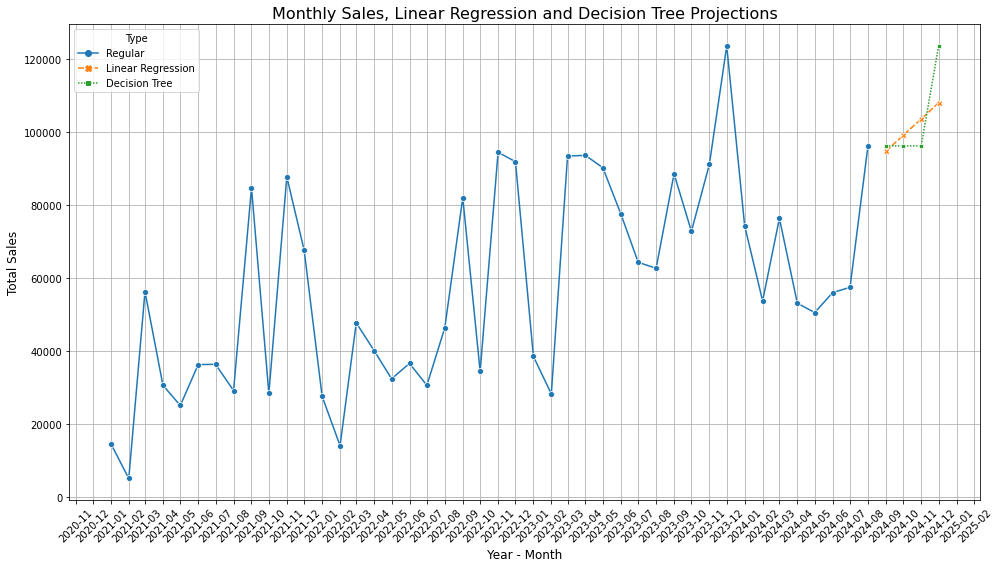

In [436]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import MonthLocator, DateFormatter

monthly_metrics['Date'] = pd.to_datetime(monthly_metrics[['Year', 'Month']].assign(DAY=1))
monthly_metrics['Date_Ordinal'] = monthly_metrics['Date'].map(lambda x: x.toordinal())

monthly_metrics["Type"] = "Regular"
lr_proj["Type"] = "Linear Regression"
dt_proj["Type"] = "Decision Tree"

df = pd.concat(
    [monthly_metrics, lr_proj, dt_proj], ignore_index=True
)

# Convert Date to datetime
df["Date"] = pd.to_datetime(df["Date"])

# Create the plot
plt.figure(figsize=(14, 8))
sns.lineplot(data=df, x="Date", y="Sales", hue="Type", style="Type", markers=True, dashes=True)

# Customize the plot
plt.title("Monthly Sales, Linear Regression and Decision Tree Projections", fontsize=16)
plt.xlabel("Year - Month", fontsize=12)
plt.ylabel("Total Sales", fontsize=12)
plt.grid(True)

# Set x-axis to show each month
ax = plt.gca()  # Get the current axes
ax.xaxis.set_major_locator(MonthLocator(interval=1))  # Show every month
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))  # Format as "Year-Month"

plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


This chart demonstrates the monthly sales projections, showcasing the performance of the Linear Regression and Decision Tree models alongside the actual historical sales data. While the Linear Regression model captures a steady and logical trend, the Decision Tree model appears to overfit, exhibiting sharp deviations that may not generalize well.

### 3.5) Visualizing Monthly Sales Projections

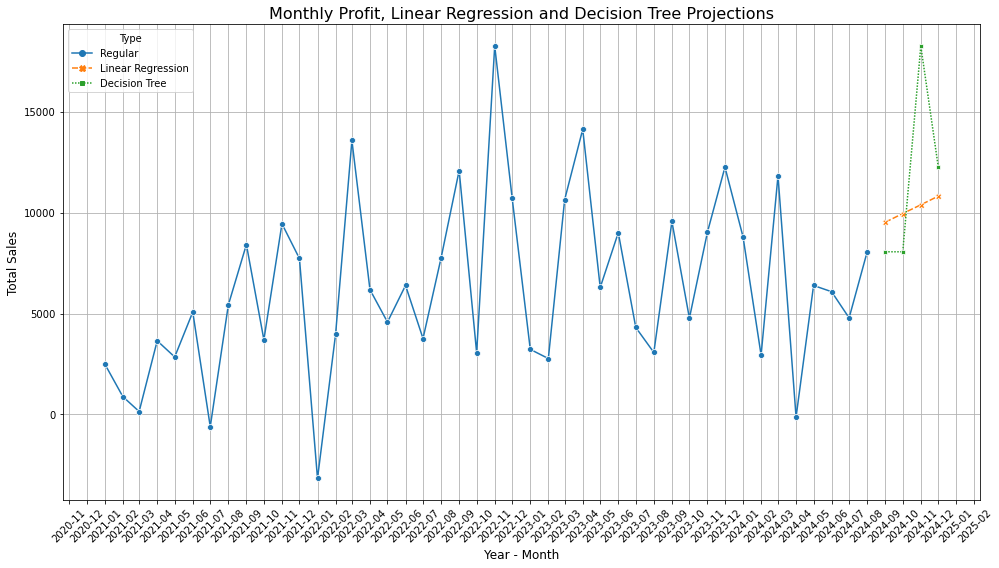

In [437]:
plt.figure(figsize=(14, 8))
sns.lineplot(data=df, x="Date", y="Profit", hue="Type", style="Type", markers=True, dashes=True)

# Customize the plot
plt.title("Monthly Profit, Linear Regression and Decision Tree Projections", fontsize=16)
plt.xlabel("Year - Month", fontsize=12)
plt.ylabel("Total Sales", fontsize=12)
plt.grid(True)

# Set x-axis to show each month
ax = plt.gca()  # Get the current axes
ax.xaxis.set_major_locator(MonthLocator(interval=1))  # Show every month
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))  # Format as "Year-Month"

plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


This chart illustrates the monthly profit trends alongside projections from the Linear Regression and Decision Tree models. While the Linear Regression model provides a consistent and flat projection, it fails to capture the increasing trends in profit, whereas the Decision Tree model shows large fluctuations in its prediction - similar to our Sales chart.


Our past numbers exhibit extreme volatile behavior so the decision tree model holds value in exhibiting this behavior albeit large fluctuations. However, from a business perspective we need more consistency in our numbers which is associated with the linear regression model.

## 4) Models on Sales and Profit across Categories

Our stakeholders have also called for us to create projection for sales and profit in the last quarter of 2024 seperated by category. The 3 categories of interest for our data set are: Furniture, Office Supplies, Technology. In this section of our notebook, we will methodically create projections of sales and profit for each of these categories and visualize them in a similar format to section 3.

### 4.1) Technology

In [464]:
# Filter the Technology (tech) category
df_total_tech = df_total[df_total['Category'] == 'Technology']

# Group by Year and Month
monthly_tech = df_total_tech.groupby(['Year', 'Month'])['Sales','Profit'].sum().reset_index()
monthly_tech = monthly_tech.iloc[:-4]


# Prepare the features and target for the regression
X_sales = monthly_tech[['Year', 'Month']].values
Y_sales = monthly_tech['Sales'].values

X_profit = monthly_tech[['Year', 'Month']].values
Y_profit = monthly_tech['Profit'].values



# Split the data into training and testing sets for SALES, keeping order, 20% test size
x_train_sales, x_test_sales, y_train_sales, y_test_sales = train_test_split(X_sales, Y_sales, 
                                                                        test_size=0.2, 
                                                                        shuffle=True, 
                                                                        random_state=42)

# Split the data into training and testing sets for PROFIT, keeping order, 20% test size
x_train_profit, x_test_profit, y_train_profit, y_test_profit = train_test_split(X_profit, Y_profit, 
                                                                                test_size=0.2, 
                                                                                shuffle=True, 
                                                                                random_state=42)

# Train the linear regression model for Profit
lr_model_profit = LinearRegression()
lr_model_profit.fit(x_train_profit, y_train_profit)

# Train the Decision tree model for Profit
dt_model_profit = DecisionTreeRegressor()
dt_model_profit.fit(x_train_profit, y_train_profit)

# Train the linear regression model for sales
lr_model_sales = LinearRegression()
lr_model_sales.fit(x_train_sales, y_train_sales)

# Train the Decision tree model for sales
dt_model_sales = DecisionTreeRegressor()
dt_model_sales.fit(x_train_sales, y_train_sales)

monthly_tech['Date'] = pd.to_datetime(monthly_tech[['Year', 'Month']].assign(DAY=1))
monthly_tech['Date_Ordinal'] = monthly_tech['Date'].map(lambda x: x.toordinal())


#### 4.1.1) Tech Projections by Linear Regression

In [465]:
future_months = [[2024,9], [2024,10], [2024,11], [2024,12]]
future_sales_tech = lr_model_sales.predict(future_months)
future_profit_tech = lr_model_profit.predict(future_months)


linear_projection_df_tech = pd.DataFrame({
    'Year': [2024,2024,2024,2024],
    'Month': [9,10,11,12],
    'Sales': future_sales_tech,
    'Profit': future_profit_tech
})

linear_projection_df_tech['Date'] = pd.to_datetime(linear_projection_df_tech[['Year', 'Month']].assign(DAY=1))
linear_projection_df_tech['Date_Ordinal'] = linear_projection_df_tech['Date'].map(lambda x: x.toordinal())

print("Projection of the Tech Sales for the Next 4 Months with Linear Regression")

linear_projection_df_tech

Projection of the Tech Sales for the Next 4 Months with Linear Regression


,Year,Month,Sales,Profit,Date,Date_Ordinal
0,2024,9,35307.096718,5062.244388,2024-09-01,739130
1,2024,10,36358.392390,5259.021199,2024-10-01,739160
2,2024,11,37409.688061,5455.798009,2024-11-01,739191
3,2024,12,38460.983733,5652.574820,2024-12-01,739221


#### 4.1.2) Tech Projections by Decision Tree

In [466]:
future_months = [[2024,9], [2024,10], [2024,11], [2024,12]]
future_sales_tech = dt_model_sales.predict(future_months)
future_profit_tech = dt_model_profit.predict(future_months)

dt_projection_df_tech = pd.DataFrame({
    'Year': [2024,2024,2024,2024],
    'Month': [9,10,11,12],
    'Sales': future_sales_tech,
    'Profit': future_profit_tech
})

dt_projection_df_tech['Date'] = pd.to_datetime(linear_projection_df_tech[['Year', 'Month']].assign(DAY=1))
dt_projection_df_tech['Date_Ordinal'] = linear_projection_df_tech['Date'].map(lambda x: x.toordinal())

print("Projection of the Tech Sales and Profit for the Next 4 Months with Decision Tree")

dt_projection_df_tech

Projection of the Tech Sales and Profit for the Next 4 Months with Decision Tree


,Year,Month,Sales,Profit,Date,Date_Ordinal
0,2024,9,34682.93,5543.47,2024-09-01,739130
1,2024,10,20069.72,2380.50,2024-10-01,739160
2,2024,11,20069.72,2562.33,2024-11-01,739191
3,2024,12,38904.95,2562.33,2024-12-01,739221


### 4.2) Office Supplies

In [467]:
# Filter the Office Supplies (o_s) category
df_total_o_s = df_total[df_total['Category'] == 'Office Supplies']

# Group by Year and Month
monthly_o_s = df_total_o_s.groupby(['Year', 'Month'])['Sales','Profit'].sum().reset_index()
monthly_o_s = monthly_o_s.iloc[:-4]


# Prepare the features and target for the regression
X_sales = monthly_o_s[['Year', 'Month']].values
Y_sales = monthly_o_s['Sales'].values

X_profit = monthly_o_s[['Year', 'Month']].values
Y_profit = monthly_o_s['Profit'].values



# Split the data into training and testing sets for SALES, keeping order, 20% test size
x_train_sales, x_test_sales, y_train_sales, y_test_sales = train_test_split(X_sales, Y_sales, 
                                                                        test_size=0.2, 
                                                                        shuffle=True, 
                                                                        random_state=42)

# Split the data into training and testing sets for PROFIT, keeping order, 20% test size
x_train_profit, x_test_profit, y_train_profit, y_test_profit = train_test_split(X_profit, Y_profit, 
                                                                                test_size=0.2, 
                                                                                shuffle=True, 
                                                                                random_state=42)

# Train the linear regression model for Profit
lr_model_profit = LinearRegression()
lr_model_profit.fit(x_train_profit, y_train_profit)

# Train the Decision tree model for Profit
dt_model_profit = DecisionTreeRegressor()
dt_model_profit.fit(x_train_profit, y_train_profit)

# Train the linear regression model for sales
lr_model_sales = LinearRegression()
lr_model_sales.fit(x_train_sales, y_train_sales)

# Train the Decision tree model for sales
dt_model_sales = DecisionTreeRegressor()
dt_model_sales.fit(x_train_sales, y_train_sales)

monthly_o_s['Date'] = pd.to_datetime(monthly_o_s[['Year', 'Month']].assign(DAY=1))
monthly_o_s['Date_Ordinal'] = monthly_o_s['Date'].map(lambda x: x.toordinal())

#### 4.2.1) Office Supply Projections by Linear Regression

In [468]:
future_months = [[2024,9], [2024,10], [2024,11], [2024,12]]
future_sales_o_s = lr_model_sales.predict(future_months)
future_profit_o_s = lr_model_profit.predict(future_months)


linear_projection_df_o_s = pd.DataFrame({
    'Year': [2024,2024,2024,2024],
    'Month': [9,10,11,12],
    'Sales': future_sales_o_s,
    'Profit': future_profit_o_s
})

linear_projection_df_o_s['Date'] = pd.to_datetime(linear_projection_df_o_s[['Year', 'Month']].assign(DAY=1))
linear_projection_df_o_s['Date_Ordinal'] = linear_projection_df_o_s['Date'].map(lambda x: x.toordinal())

print("Projection of the Office Supplies Sales and Profit for the Next 4 Months with Linear Regression")

linear_projection_df_o_s

Projection of the Office Supplies Sales and Profit for the Next 4 Months with Linear Regression


,Year,Month,Sales,Profit,Date,Date_Ordinal
0,2024,9,28848.107203,3625.700133,2024-09-01,739130
1,2024,10,30156.840850,3792.792618,2024-10-01,739160
2,2024,11,31465.574496,3959.885103,2024-11-01,739191
3,2024,12,32774.308142,4126.977589,2024-12-01,739221


#### 4.2.2) Office Supply Projections by Decision Tree

In [469]:
future_months = [[2024,9], [2024,10], [2024,11], [2024,12]]
future_sales_o_s = dt_model_sales.predict(future_months)
future_profit_o_s = dt_model_profit.predict(future_months)

dt_projection_df_o_s = pd.DataFrame({
    'Year': [2024,2024,2024,2024],
    'Month': [9,10,11,12],
    'Sales': future_sales_o_s,
    'Profit': future_profit_o_s
    
})

dt_projection_df_o_s['Date'] = pd.to_datetime(dt_projection_df_o_s[['Year', 'Month']].assign(DAY=1))
dt_projection_df_o_s['Date_Ordinal'] = dt_projection_df_o_s['Date'].map(lambda x: x.toordinal())


print("Projection of the Office Supplies Sales and Profit for the Next 4 Months with Decision Tree")

dt_projection_df_o_s

Projection of the Office Supplies Sales and Profit for the Next 4 Months with Decision Tree


,Year,Month,Sales,Profit,Date,Date_Ordinal
0,2024,9,43293.42,5273.84,2024-09-01,739130
1,2024,10,43293.42,2699.07,2024-10-01,739160
2,2024,11,43293.42,7902.81,2024-11-01,739191
3,2024,12,40858.71,7902.81,2024-12-01,739221


### 4.3) Furniture

In [470]:
# Filter the Furniture Supplies (f) category
df_total_f = df_total[df_total["Category"] == "Furniture"]

# Group by Year and Month
monthly_f = df_total_f.groupby(['Year', 'Month'])['Sales','Profit'].sum().reset_index()
monthly_f = monthly_f.iloc[:-4]


# Prepare the features and target for the regression
X_sales = monthly_f[['Year', 'Month']].values
Y_sales = monthly_f['Sales'].values

X_profit = monthly_f[['Year', 'Month']].values
Y_profit = monthly_f['Profit'].values



# Split the data into training and testing sets for SALES, keeping order, 20% test size
x_train_sales, x_test_sales, y_train_sales, y_test_sales = train_test_split(X_sales, Y_sales, 
                                                                        test_size=0.2, 
                                                                        shuffle=True, 
                                                                        random_state=42)

# Split the data into training and testing sets for PROFIT, keeping order, 20% test size
x_train_profit, x_test_profit, y_train_profit, y_test_profit = train_test_split(X_profit, Y_profit, 
                                                                                test_size=0.2, 
                                                                                shuffle=True, 
                                                                                random_state=42)

# Train the linear regression model for Profit
lr_model_profit = LinearRegression()
lr_model_profit.fit(x_train_profit, y_train_profit)

# Train the Decision tree model for Profit
dt_model_profit = DecisionTreeRegressor()
dt_model_profit.fit(x_train_profit, y_train_profit)

# Train the linear regression model for sales
lr_model_sales = LinearRegression()
lr_model_sales.fit(x_train_sales, y_train_sales)

# Train the Decision tree model for sales
dt_model_sales = DecisionTreeRegressor()
dt_model_sales.fit(x_train_sales, y_train_sales)

monthly_f['Date'] = pd.to_datetime(monthly_f[['Year', 'Month']].assign(DAY=1))
monthly_f['Date_Ordinal'] = monthly_f['Date'].map(lambda x: x.toordinal())





#### 4.3.1) Furniture Projections by Linear Regression

In [471]:
future_months = [[2024,9], [2024,10], [2024,11], [2024,12]]
future_sales_f = lr_model_sales.predict(future_months)
future_profit_f = lr_model_profit.predict(future_months)

linear_projection_df_f = pd.DataFrame({
    'Year': [2024,2024,2024,2024],
    'Month': [9,10,11,12],
    'Sales': future_sales_f,
    'Profit': future_profit_f
})

linear_projection_df_f['Date'] = pd.to_datetime(linear_projection_df_f[['Year', 'Month']].assign(DAY=1))
linear_projection_df_f['Date_Ordinal'] = linear_projection_df_f['Date'].map(lambda x: x.toordinal())

print("Projection of the Furniture Sales ans Profit for the Next 4 Months with Linear Regression")

linear_projection_df_f

Projection of the Furniture Sales ans Profit for the Next 4 Months with Linear Regression


,Year,Month,Sales,Profit,Date,Date_Ordinal
0,2024,9,30526.777419,831.984524,2024-09-01,739130
1,2024,10,32592.053316,899.223562,2024-10-01,739160
2,2024,11,34657.329212,966.462601,2024-11-01,739191
3,2024,12,36722.605109,1033.701640,2024-12-01,739221


#### 4.3.2) Furniture Projections by Decision Tree

In [472]:
future_months = [[2024,9], [2024,10], [2024,11], [2024,12]]
future_sales_f = dt_model_sales.predict(future_months)
future_profit_f = dt_model_profit.predict(future_months)

dt_projection_df_f = pd.DataFrame({
    'Year': [2024,2024,2024,2024],
    'Month': [9,10,11,12],
    'Sales': future_sales_f,
    'Profit': future_profit_f
})

dt_projection_df_f['Date'] = pd.to_datetime(dt_projection_df_f[['Year', 'Month']].assign(DAY=1))
dt_projection_df_f['Date_Ordinal'] = dt_projection_df_f['Date'].map(lambda x: x.toordinal())

print("Projection of the Furniture Sales and Profit for the Next 4 Months with Decision Trees")

dt_projection_df_f

Projection of the Furniture Sales and Profit for the Next 4 Months with Decision Trees


,Year,Month,Sales,Profit,Date,Date_Ordinal
0,2024,9,33468.52,1911.13,2024-09-01,739130
1,2024,10,24814.52,-313.43,2024-10-01,739160
2,2024,11,43770.19,4107.97,2024-11-01,739191
3,2024,12,43770.19,1783.20,2024-12-01,739221


### 4.4) Graphs on Sales and Profit across Categories

#### 4.4.1) Sales Visualized by Category

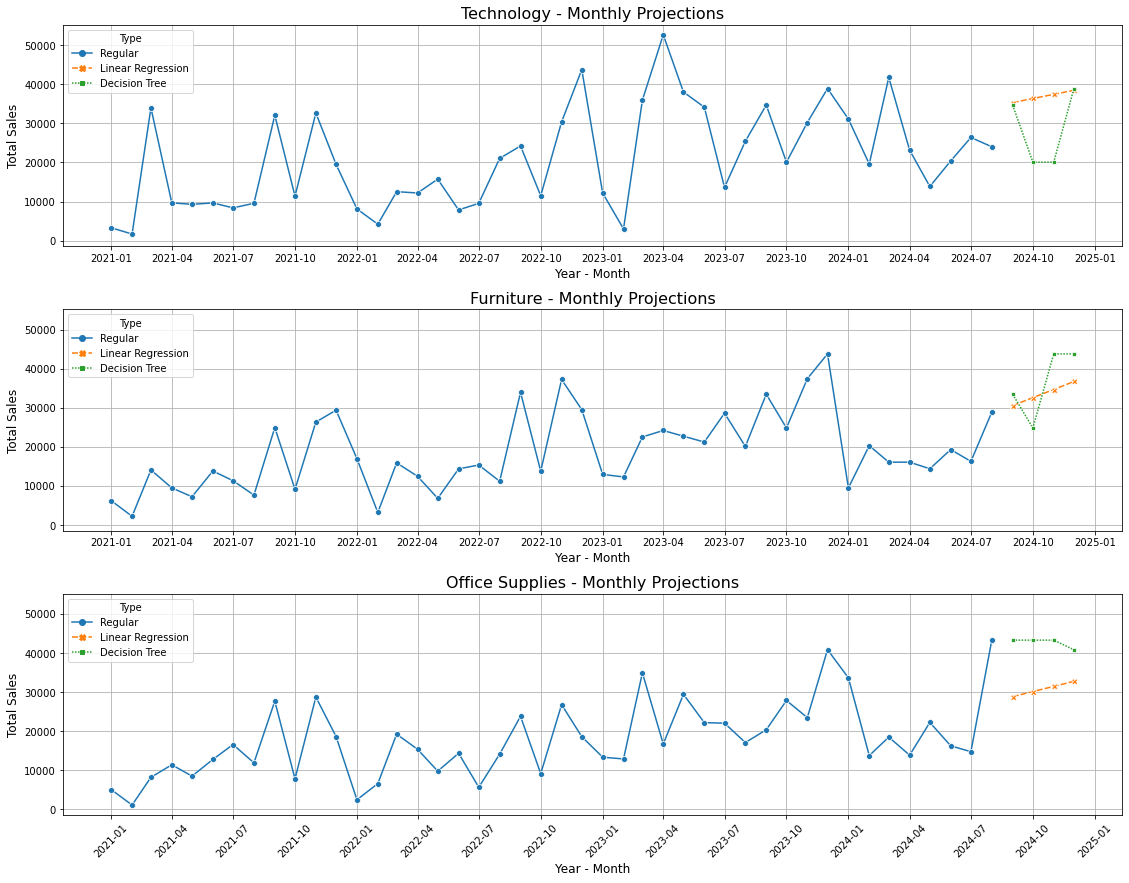

In [473]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import MonthLocator, DateFormatter

# Tech data
monthly_tech["Type"] = "Regular"
linear_projection_df_tech["Type"] = "Linear Regression"
dt_projection_df_tech["Type"] = "Decision Tree"

tech = pd.concat(
    [monthly_tech, linear_projection_df_tech, dt_projection_df_tech], ignore_index=True
)

# Furniture data
# Ensure the Linear Regression DataFrame is properly constructed and added
monthly_f["Type"] = "Regular"
linear_projection_df_f["Type"] = "Linear Regression"  # Ensure this exists and is formatted correctly
dt_projection_df_f["Type"] = "Decision Tree"

# Concatenate all furniture data into one DataFrame
furn = pd.concat(
    [monthly_f, linear_projection_df_f, dt_projection_df_f], ignore_index=True
)

# Office Supplies data
monthly_o_s["Type"] = "Regular"
linear_projection_df_o_s["Type"] = "Linear Regression"
dt_projection_df_o_s["Type"] = "Decision Tree"

office = pd.concat(
    [monthly_o_s, linear_projection_df_o_s, dt_projection_df_o_s], ignore_index=True
)

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharey=True)

# Tech subplot
sns.lineplot(data=tech, x="Date", y="Sales", hue="Type", style="Type", markers=True, dashes=True, ax=axes[0])
axes[0].set_title("Technology - Monthly Projections", fontsize=16)
axes[0].set_xlabel("Year - Month", fontsize=12)
axes[0].set_ylabel("Total Sales", fontsize=12)
axes[0].grid(True)
axes[0].xaxis.set_major_locator(MonthLocator(interval=1))  # Set monthly ticks
axes[0].xaxis.set_major_formatter(DateFormatter("%Y-%m"))  # Format ticks

# Furniture subplot
sns.lineplot(data=furn, x="Date", y="Sales", hue="Type", style="Type", markers=True, dashes=True, ax=axes[1])
axes[1].set_title("Furniture - Monthly Projections", fontsize=16)
axes[1].set_xlabel("Year - Month", fontsize=12)
axes[1].set_ylabel("Total Sales", fontsize=12)
axes[1].grid(True)
axes[1].xaxis.set_major_locator(MonthLocator(interval=1))  # Set monthly ticks
axes[1].xaxis.set_major_formatter(DateFormatter("%Y-%m"))  # Format ticks

# Office Supplies subplot
sns.lineplot(data=office, x="Date", y="Sales", hue="Type", style="Type", markers=True, dashes=True, ax=axes[2])
axes[2].set_title("Office Supplies - Monthly Projections", fontsize=16)
axes[2].set_xlabel("Year - Month", fontsize=12)
axes[2].set_ylabel("Total Sales", fontsize=12)
axes[2].grid(True)
axes[2].xaxis.set_major_locator(MonthLocator(interval=3))  # Set tri-monthly ticks
axes[2].xaxis.set_major_formatter(DateFormatter("%Y-%m"))  # Format ticks

# Adjust layout and show the plots
plt.tight_layout()
plt.setp(axes, xticks=axes[2].get_xticks())  # Synchronize x-ticks
plt.xticks(rotation=45)
plt.show()


#### 4.4.2) Profit Visualized by Category

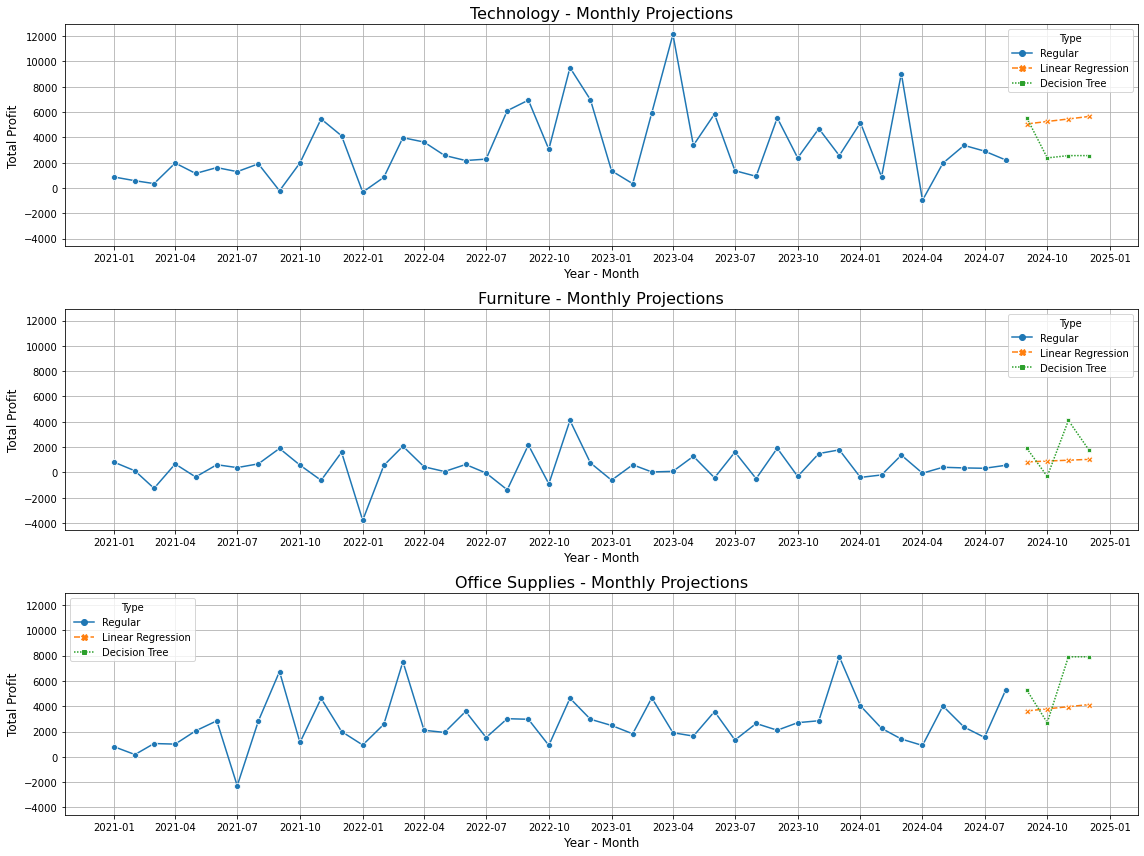

In [474]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import MonthLocator, DateFormatter

# Ensure the dates and data are properly formatted
tech["Date"] = pd.to_datetime(tech["Date"])
furn["Date"] = pd.to_datetime(furn["Date"])
office["Date"] = pd.to_datetime(office["Date"])

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharey=True)

# Plot Technology data
sns.lineplot(data=tech, x="Date", y="Profit", hue="Type", style="Type", markers=True, dashes=True, ax=axes[0])
axes[0].set_title("Technology - Monthly Projections", fontsize=16)
axes[0].set_xlabel("Year - Month", fontsize=12)
axes[0].set_ylabel("Total Profit", fontsize=12)
axes[0].grid(True)
axes[0].xaxis.set_major_locator(MonthLocator(interval=3))  # Show every 3rd month
axes[0].xaxis.set_major_formatter(DateFormatter("%Y-%m"))  # Format ticks as "Year-Month"
axes[0].tick_params(axis="x", labelsize=10)  # Reduce x-axis label size

# Plot Furniture data
sns.lineplot(data=furn, x="Date", y="Profit", hue="Type", style="Type", markers=True, dashes=True, ax=axes[1])
axes[1].set_title("Furniture - Monthly Projections", fontsize=16)
axes[1].set_xlabel("Year - Month", fontsize=12)
axes[1].set_ylabel("Total Profit", fontsize=12)
axes[1].grid(True)
axes[1].xaxis.set_major_locator(MonthLocator(interval=3))  # Show every 3rd month
axes[1].xaxis.set_major_formatter(DateFormatter("%Y-%m"))  # Format ticks as "Year-Month"
axes[1].tick_params(axis="x", labelsize=10)  # Reduce x-axis label size

# Plot Office Supplies data
sns.lineplot(data=office, x="Date", y="Profit", hue="Type", style="Type", markers=True, dashes=True, ax=axes[2])
axes[2].set_title("Office Supplies - Monthly Projections", fontsize=16)
axes[2].set_xlabel("Year - Month", fontsize=12)
axes[2].set_ylabel("Total Profit", fontsize=12)
axes[2].grid(True)
axes[2].xaxis.set_major_locator(MonthLocator(interval=3))  # Show every 3rd month
axes[2].xaxis.set_major_formatter(DateFormatter("%Y-%m"))  # Format ticks as "Year-Month"
axes[2].tick_params(axis="x", labelsize=10)  # Reduce x-axis label size

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


Based on the projections for the fourth quarter of 2024 across profit and sales for the categories of technology, office supplies, and furniture, both the Linear Regression and Decision Tree models provide valuable insights into future sales and profit trends across categories. The Linear Regression model demonstrates consistent predictions that align with overall trends, making it suitable for long-term strategic forecasting. On the other hand, the Decision Tree model captures nuanced fluctuations and localized patterns, which can be useful for category specific tactical decisions.

However, the Decision Tree’s projections exhibit higher variability, suggesting a potential overfitting to specific patterns in the training data. In contrast, the Linear Regression model offers smoother and more stable forecasts. For strategic purposes, Linear Regression may be preferred for its stability, while the Decision Tree model could be leveraged in areas with unique seasonal or categorical variables. These insights allow us to tailor our strategies to maximize profit and sales growth in the coming quarters.

## 4) Conclusion

In analyzing the performance of both the Linear Regression and Decision Tree models, each demonstrates distinct strengths and weaknesses that make them suitable for different forecasting scenarios. The Linear Regression model provides steady, linear predictions with minimal variance, offering consistency and ease of interpretation. This stability is beneficial for creating long-term forecasts and making strategic business decisions. However, it fails to capture natural fluctuations in the data, such as seasonality, trends, or changes in consumer behavior, which can lead to oversimplified results.

Conversely, the Decision Tree model exhibits greater sensitivity to fluctuations, better capturing complex patterns and variations in the data. While this allows the model to respond to seasonality and sudden shifts in trends, the resulting predictions often come with higher variance, making them less reliable and harder to explain from a business perspective.

One notable observation is that both models frequently yielded negative R^2 values, indicating that a simple mean-based prediction could outperform our models as currently implemented. To improve model accuracy and the R^2 values, we recommend incorporating additional features into the predictive modelling. These could include seasonality variables (e.g., month or quarter), macroeconomic indicators (e.g., GDP growth or inflation rates), or contextual factors such as promotions and holidays. Additionally, engineering features like rolling averages, lagged sales, or consumer sentiment metrics could help the models better capture the underlying variability in the data. By enriching the dataset with these predictors and experimenting with advanced time-series models, we can create forecasts that align more closely with real-world trends and consumer behavior.

Considering these factors, we would **recommend using the Linear Regression model** as it provides more predictable and actionable results for Q4 2024 sales and profit forecasts. While it may not capture every fluctuation, its simplicity and consistency align better with the needs of strategic planning and high-level business insights. That said, the Decision Tree model could serve as a supplementary tool for identifying category-specific or short-term trends when greater flexibility is required.

# Request 2: Customer Purchasing Predicitve Model

## 1) Context:

With our forecasting of future sales done, our next goal is to develop a predictive model that identifies whether a customer will make a purchase based on past customer purchasing data. This model will enable our business to optimize operations in three key ways:

1. By focusing resources on high-potential buyers, enhancing marketing efficiency, personalization, and customer experience.


2. By streamlining interventions such as discounts or assistance, targeting only those customers who need them, while increasing revenue through upselling, cross-selling, and reducing cart abandonment.


3. By providing actionable insights into customer behavior and informing strategic decisions to drive higher conversions and profitability.

We will begin by processing our gathered customer dataset and analyzing what metrics we can use to build the foundation of our predictive model.

## 2) Data Loading and Initial Analytics. 

In [382]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Reading the CSV file Method 1 for Dates (note for x data is european so decimal is comma)
x = pd.read_csv('ACME_customers.csv')

# Check for NA values
na_per_column = x.isna().sum()

# Check to see if there are any Dtypes that need to be changed
x.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CustomerID              20000 non-null  object 
 1   Gender                  20000 non-null  object 
 2   AgeGroup                20000 non-null  object 
 3   CategoryVisited         20000 non-null  object 
 4   NumPagesViewed          20000 non-null  int64  
 5   DeviceUsed              20000 non-null  object 
 6   ReferralSource          20000 non-null  object 
 7   CartValue               20000 non-null  float64
 8   PreferredPaymentMethod  20000 non-null  object 
 9   DiscountApplied         20000 non-null  object 
 10  DiscountAmount          20000 non-null  float64
 11  PurchaseMade            20000 non-null  object 
 12  Segment                 20000 non-null  object 
 13  YearsOfMembership       20000 non-null  int64  
 14  LoyaltyPoints           20000 non-null

### 2.1) Synopsis of Variables:
Upon initial inspection, our data-set apears to be well formatted for our model creation with proper data types for each of our variables and no missing values. Below is a description of each of the variables in our data-set. 


* **CustomerID**: A unique identifier for each customer in the dataset.

* **Gender**: The gender of the customer (e.g., Male, Female).

* **AgeGroup**: The age range of the customer (e.g., 18-24, 25-34).

* **CategoryVisited**: The primary product category most frequently visited by the customer (e.g., Furniture, Technology).

* **NumPagesViewed**: The total number of pages viewed by the customer on the website.

* **DeviceUsed**: The type of device the customer used to access the website (e.g., Mobile, Desktop, Tablet).

* **ReferralSource**: The source through which the customer was referred to the website (e.g., Social Media, Email, Direct).

* **CartValue**: The total monetary value of items in the customer’s cart.

* **PreferredPaymentMethod**: The payment method preferred by the customer (e.g., Credit Card, PayPal).

* **DiscountApplied**: Indicates whether a discount was applied to the customer’s purchase (e.g., Yes/No).

* **DiscountAmount**: The monetary value of the discount applied to the customer’s purchase.

* **PurchaseMade**: Indicates whether the customer completed a purchase (e.g., Yes/No).

* **Segment**: The customer’s market segment (e.g., Consumer, Corporate).

* **YearsOfMembership**: The number of years the customer has been a member of the platform.

* **LoyaltyPoints**: The total number of loyalty points the customer has accrued.

* **LoyaltyTier**: The loyalty program tier of the customer (e.g., Bronze, Silver, Gold).

* **State**: The state where the customer resides.

Let us dive in a step further and view the contents of each of these metrics and the dataset as a whole

### 2.2 Decriptive and Visual Analytics

In [383]:
# Summary of numeric value
x.describe()

,NumPagesViewed,CartValue,DiscountAmount,YearsOfMembership,LoyaltyPoints
count,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000
mean,10.05425,1043.902090,0.286925,5.504200,2350.393800
std,5.47980,521.023912,0.265927,2.866425,1361.216296
min,1.00000,13.073600,0.000000,1.000000,100.000000
25%,5.00000,652.809100,0.100000,3.000000,1268.000000
50%,10.00000,1030.538800,0.200000,5.000000,1997.000000
75%,15.00000,1397.122000,0.500000,8.000000,3519.000000
max,19.00000,2877.781800,0.800000,10.000000,4999.000000


In [384]:
# Summary of Non-numeric values
x.describe(include = ['object'])

,CustomerID,Gender,AgeGroup,CategoryVisited,DeviceUsed,ReferralSource,PreferredPaymentMethod,DiscountApplied,PurchaseMade,Segment,LoyaltyTier,State
count,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000
unique,19997,2,6,3,4,4,4,2,2,3,4,6
top,TK-70143,Male,25-34,Furniture,Laptop,Email,Credit Card,Yes,No,Corporate,Gold,New York
freq,2,10042,3465,6753,6997,5037,6688,15338,11858,6711,5111,3437


With our descriptions above, we can see the averages and general spread of our numerical data like the number of pages viewed and cart values. We can also see the unique number of instances of our categorical areas, such as 6 different detected age groups, purchases from 6 different states, and 3 different categories on our website that our visited. 

With ~20,000 unique rows of customer purchase information, we can compare the spread of our variables from those who did purchase versus those who did not make a purchase to find any patterns:

In [385]:
x.groupby('PurchaseMade').describe()

NumPagesViewed                                                    \
                      count       mean       std  min   25%   50%   75%   max   
PurchaseMade                                                                    
No                  11858.0   8.217912  5.339395  1.0   4.0   7.0  12.0  19.0   
Yes                  8142.0  12.728691  4.492110  1.0  11.0  13.0  16.0  19.0   

             CartValue               ... YearsOfMembership        \
                 count         mean  ...               75%   max   
PurchaseMade                         ...                           
No             11858.0  1004.354433  ...               8.0  10.0   
Yes             8142.0  1101.499256  ...               8.0  10.0   

             LoyaltyPoints                                                   \
                     count         mean          std    min     25%     50%   
PurchaseMade                                                                  
No                 11858.0  2302.584500  1347.081936  100.0  1250.0  1948.0   
Yes                 8142.0  2420.023213  1378.663267  100.0  1292.0  2154.0   

                               
                  75%     max  
PurchaseMade                   
No            3415.50  4999.0  
Yes           3630.75  4999.0  

[2 rows x 40 columns]

Through our analysis of whether a purhchase was made or not, we can see that ~8,000 customers made purchases while ~12,000 customers did not make purchases. Here we see a 2:3 ratio between purchases made and purchases not made. These metrics are important for us to use as a baseline as we work to predict whether a purhcase will be made or not.

Let's begin visually analyzing our data to see any patterns, correlation, and any other important statistics.

<Figure size 864x432 with 0 Axes>

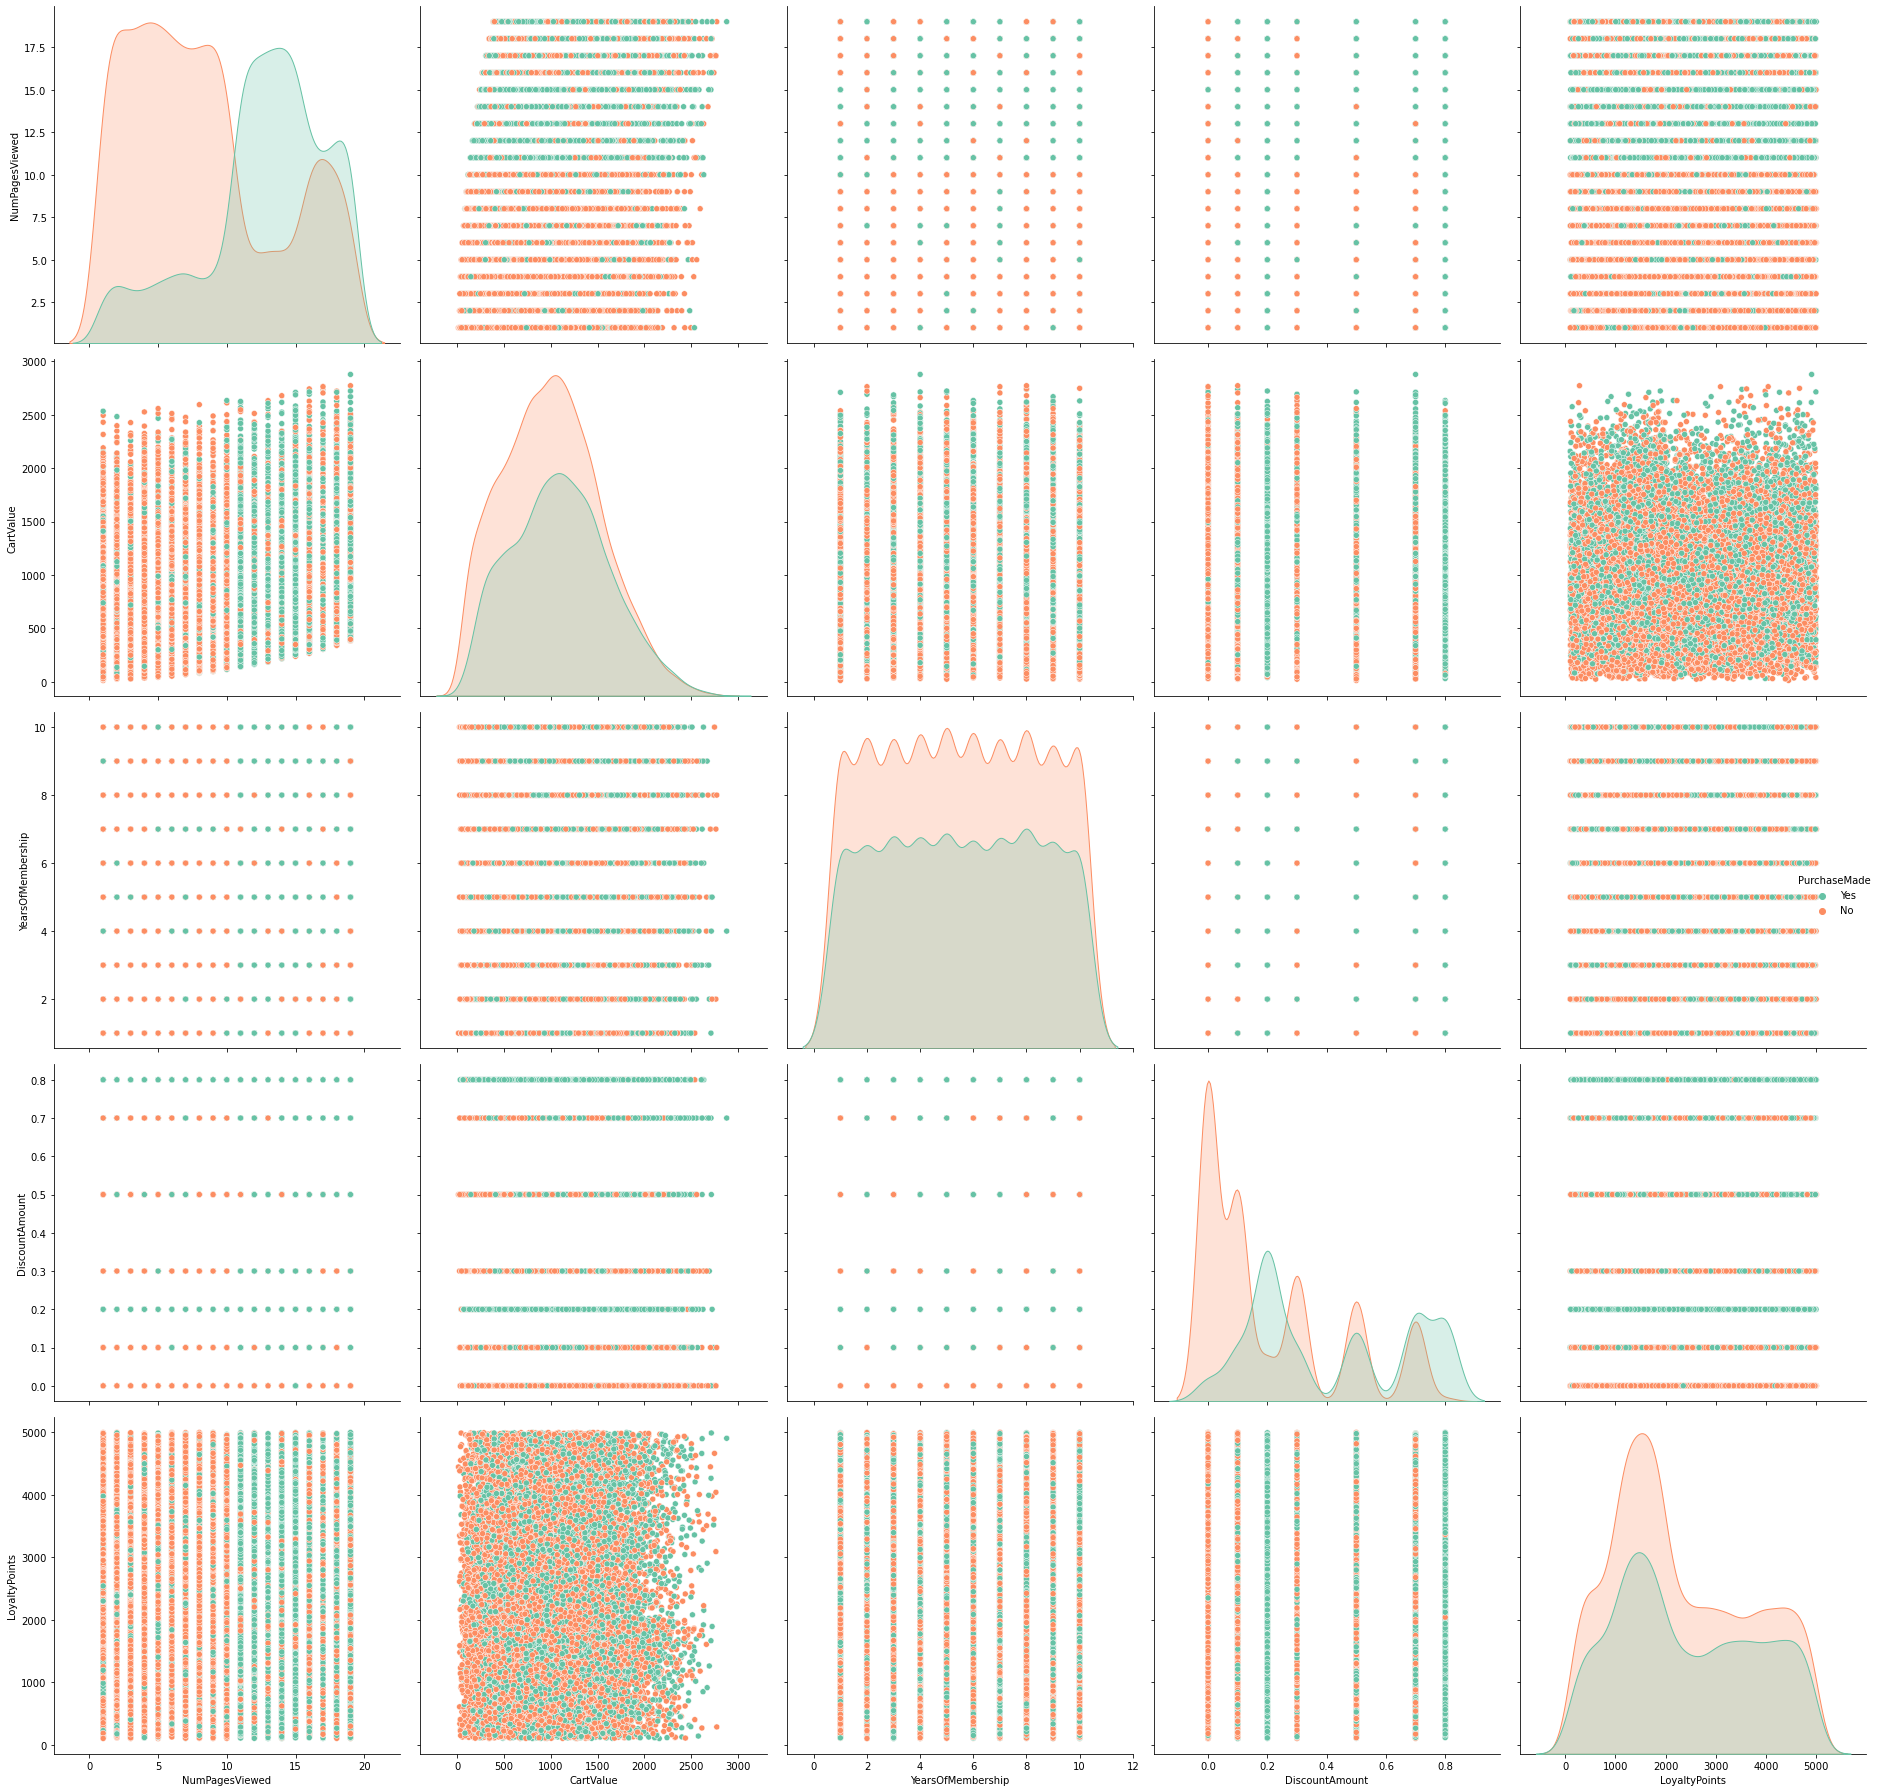

In [386]:
plt.figure(figsize = (12,6))

cols_for_pairplot = ['NumPagesViewed', 'CartValue', "YearsOfMembership", "DiscountAmount", "LoyaltyPoints", "Gender", "AgeGroup", "PurchaseMade"]
df_pairplot = x[cols_for_pairplot]


sns.pairplot(df_pairplot,vars = df_pairplot.columns[:-3], hue = "PurchaseMade",  height = 5, palette = "Set2")


plt.tight_layout()
plt.show()


Our graphs above help us understand the distribution of purchasing habits from our population according to each quantifiable metric available to us in our data set. With individuals who completed a purchase denoted in green and those who decided the not purchase in red, we can point out 3 major observations:

1. There is an extremely sharp difference in customers purchasing habits once a user has viewed over 10 pages. Our visualization **dentoes 10 pages to be the turning point at which user's willingness to purchase switches from a "no" in purchasing to a "yes"**.


2. There is an apparent pattern present in purchasing habits with respect to Discount Amount. Most custumors tend to lean towrds not purchasing their cart with discounts below 15%, with a large number of purchases being made when there is a **20% Discount**. This is interesting as we see a drop in the ratio between purchases being made and not made after moving from a 20% discount to a 30% discount. This pattern remains constant up until around 70% where we see more purchases being made, and specifically at **80% Discount** where we see a very high percentage of purchases. Many people are drawn to making purchases based on whether there is a discount. However, from our analysis, we get a deeper dive into our customer's willingness to purhcase based of discounts and see that a large percentage of **customers tend to purchase when there is a discount of 20% or 80%**.

3. There is no distinct pattern in purchasing habits with respect to Cart Value, Loyalty Points, or Years of Membership. A consisitent porportion of 2 "yes's" for every 3 "no's" holds for the entirety of these metrics despite any change. 

Let's also observe our customers purchasing habits based on some demographic information: Gender and Age Group:

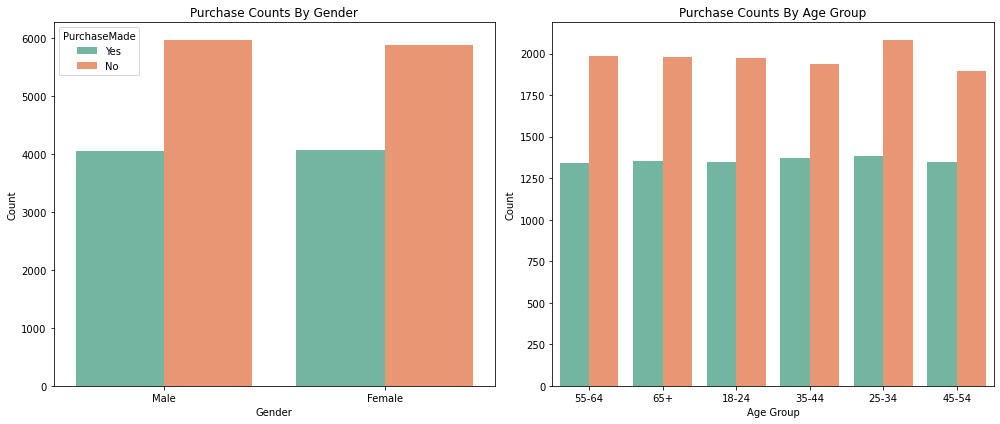

In [387]:
# Graphing barplot
fig, axes = plt.subplots(1,2, figsize = (14,6))

sns.countplot(x = "Gender", data = x, hue = "PurchaseMade", palette = "Set2", ax=axes[0])
axes[0].set_title('Purchase Counts By Gender')
axes[0].set_xlabel('Gender')  
axes[0].set_ylabel('Count')  

sns.countplot(x = "AgeGroup",  data = x, hue = "PurchaseMade", palette = "Set2", ax=axes[1])

axes[1].set_title('Purchase Counts By Age Group')  
axes[1].set_xlabel('Age Group')          
axes[1].set_ylabel('Count')  
axes[1].legend().remove()


plt.tight_layout()
plt.show()

For our plots with purchasing habits filtered by gender and age group, there is also no distinct variation in our "yes's" and "no's" as the variable switches from category to category. What is still apparent is 2 "yes's" for every 3 "no's" holds for the entirety of these metrics.

Let's take a moment to step away from our variables relationship with purchases made and look towards our variables relationship with one another. This is important to understand as we begin our building our model as we want to avoid any redundency in our model training. For example, we want to avoid our model having 2 columns that share the same information, making that information weight more heavily in our prediction than others. 

Text(0.5, 1.0, 'Correlation of Data')

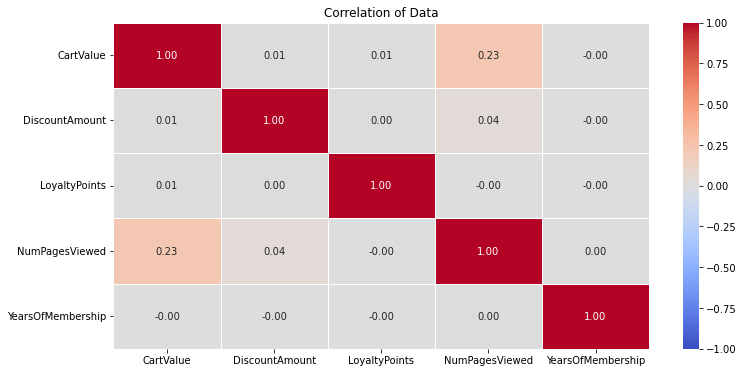

In [388]:
# Create a correlation matrix across our numerical variables

selected_cols = [
 'CartValue',
 'DiscountAmount',
 'LoyaltyPoints',
 'LoyaltyTier',
 'NumPagesViewed',
 'PurchaseMade',
 'YearsOfMembership']

x_correlation_matrix = x[selected_cols].corr()

plt.figure(figsize = (12,6))
sns.heatmap(x_correlation_matrix, annot = True, linewidth = .5, fmt = ".2f", cmap = "coolwarm", vmin = -1, vmax = 1)

plt.title('Correlation of Data')

As seen in the correlation matrix above, most variables show very low correlation coefficients, indicating little to no linear relationship between them. The only modest correlation is between "CartValue" and "NumPagesViewed" with a correlation of 0.23, which suggests a slight positive association, implying that customers who view more pages may tend to have higher cart values, though the relationship is not strong.

## 3) Classification Models & Evaluation.

After completing some analysis of our data, we will now begin the creation of our predicitve model. The model will be trained on all of the relevent data available to us in our customers dataset. With that said, we need to go through our dataset and filter out any variables that are unfit for our model training or redundent in information as we previously explained.

### 3.1) Key Variables to Include
1. **Demographic Information**
* Gender: Gender can influence purchasing patterns.
* AgeGroup: Different age groups might have varying preferences and purchasing tendencies.
2. **Behavioral Data**
* CategoryVisited: The category of items visited may indicate interest in a specific type of product.
* NumPagesViewed: Higher engagement (viewing more pages) might correlate with a higher likelihood of purchasing.
3. **Technical Information**
* DeviceUsed: Different devices (e.g., mobile vs. desktop) can influence user behavior and purchase likelihood.
* ReferralSource: Knowing whether the customer came through direct, social media, or search can help identify intent.
4. **Monetary Metrics**
* CartValue: Higher cart values could indicate greater purchasing intent.
* DiscountApplied: Discounts often incentivize purchases.
* DiscountAmount: The size of the discount could further explain purchasing behavior.
5. **Customer Loyalty and Engagement**
* YearsOfMembership: Long-standing customers might be more loyal and likely to purchase.
* LoyaltyPoints: Higher loyalty points could indicate greater engagement.
* LoyaltyTier: Membership tiers (e.g., Gold, Silver) often reflect customer activity and value.
6. **Geographical Data**
* State: Regional preferences and buying patterns may vary.

### 3.2) Variables to Exclude
* CustomerID: This is a unique identifier and does not provide predictive value.
* Segment: Depending on how it's derived, it might be redundant with other variables (e.g., AgeGroup or LoyaltyTier).
* PreferredPaymentMethod: As all payments are card or electronic based, not much varition to be worked with.

### 3.3) Data Restructuring 
Our models will be primarily trained with numerical components, with that said we will first filter out our deemed unneccesary columns and encode our categorical columns into numerical values. 

In [392]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd
# Taking out irrelevent Data Columns

# Drop columns
columns_to_drop = ['CustomerID', "Segment", 'PreferredPaymentMethod' ]
x_dropped = x.drop(columns=columns_to_drop)


# Ordinal Encoding on LoyaltyTier, Age-Group, and all Binary Data
categories = [
    ["Male", "Female"],
    ["18-24", "25-34", "35-44", "45-54", "55-64", "65+"],
    ['Bronze', 'Silver', 'Gold', 'Platinum'],  
    ["No", "Yes"],
    ["No", "Yes"]
]

encoder = OrdinalEncoder(categories=categories)

x_dropped[['Gender', 'AgeGroup', "LoyaltyTier", "DiscountApplied", "PurchaseMade"]] = encoder.fit_transform(
    x_dropped[['Gender', 'AgeGroup', "LoyaltyTier", "DiscountApplied", "PurchaseMade"]]
              )

# One-Hot encoding on Nominal Data
x_dropped = pd.get_dummies(x_dropped, columns=['CategoryVisited', 'DeviceUsed', 'State', "ReferralSource"], 
                           prefix=['Category', 'Device',  'State', 'Referral'],
                          drop_first=True)

### 3.4 Logistic Regression Classification - Model A

Our first model denoted as Model A will utilize a Logistic Regression model to classify instances of customer information to predict whether they will be an individual who will make a purchase or not. The model is then trained on the scaled data and evaluated using a classification report to assess its performance.

We deemed the logistion regression classification technique to be interesting as it is a practical and reliable model for predicting whether a customer will make a purchase on a website. It provides clear probabilities for decision-making, making it easy to interpret which factors influence purchasing behavior. This allows businesses to better target high-potential customers and optimize their marketing strategies efficiently.

In [395]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
import pandas as pd
import numpy as np


#Define X and Y
X = x_dropped.drop(columns = ['PurchaseMade'])
Y = x_dropped['PurchaseMade']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split with scaled data
x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, shuffle=True, random_state=42)

# Train the model again
model = LogisticRegression(random_state=42)
model.fit(x_train, y_train)

# Make Prediction and Evaluation
y_pred = model.predict(x_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.81      0.81      0.81      2408
         1.0       0.71      0.72      0.71      1592

    accuracy                           0.77      4000
   macro avg       0.76      0.76      0.76      4000
weighted avg       0.77      0.77      0.77      4000



**Note: Class 0.0 denotes individuals who did not make a purchase, class 1.0 denotes those who did make a purchase.**

The logistic regression model achieved an overall accuracy of 77%, indicating it correctly classified 77% of the test instances. The model performs slightly better for the majority class (0.0) with an F1-score of 0.81 compared to 0.71 for the minority class (1.0). 

Our F-1 score takes into the account our models:
* Precision (*proportion of correctly predicted 0 or 1 instances out of all instances predicted as 0 or 1, respectively*) and 
* Recall - (*proportion of correctly predicted 0 or 1 instances out of all instances of that are actually 0 or 1, respectively*). 

This suggests that while the model is reasonably effective overall, it struggles more with identifying individuals likely to make a purchase, as evidenced by the lower precision and recall for class 1.0. While the model demonstrates solid performance in classifying the majority class, its lower performance in identifying the minority class highlights an opportunity to refine the model or rebalance the dataset, ensuring more equitable and actionable predictions that better align with business objectives.

### 3.4.1) k-Fold

In [396]:
# Initialize the Decision Tree
# Define 5-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation 
model = LogisticRegression(random_state = 42)
cv_scores = cross_val_score (model, X_scaled, Y, cv=kf)

# Output the cross-validation scores
print("Cross-validation scores for each fold:", cv_scores) 
print("Average cross-validation score:", np.mean (cv_scores))

Cross-validation scores for each fold: [0.77175 0.766   0.769   0.771   0.7765 ]
Average cross-validation score: 0.77085


The cross-validation results show an average accuracy of approximately 77.1%, which aligns closely with the accuracy observed in the initial test set evaluation. This consistency across folds suggests that the model is stable and generalizes well to unseen data. While the performance is reliable, the relatively modest accuracy indicates there may still be room for improvement in predicting customer purchase behavior, especially for the minority class.

### 3.5) Random Forest Classification-Model B

Our second model, implemented using a Random Forest Classifier, aims to classify instances of customer information to predict whether a purchase will be made. This approach builds an ensemble of decision trees, combining their predictions to improve accuracy and robustness. The model was trained using scaled features and evaluated on the test set, providing a comprehensive classification report to assess its precision, recall, and F1-score for each class. The Random Forest Classifier leverages its ability to capture non-linear patterns, offering improved performance over the Logistic Regression model.

In [475]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
import pandas as pd
import numpy as np



x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, test_size = 0.2,
                                                   shuffle = True,
                                                   random_state = 42) 
#Create and train the Logistics

model = RandomForestClassifier(random_state = 42)
model.fit(x_train, y_train)

#Make Pred and Eval
y_pred = model.predict(x_test)
report = classification_report(y_test, y_pred)
print(report)




              precision    recall  f1-score   support

         0.0       0.86      0.89      0.88      2408
         1.0       0.82      0.79      0.81      1592

    accuracy                           0.85      4000
   macro avg       0.84      0.84      0.84      4000
weighted avg       0.85      0.85      0.85      4000



The Random Forest model achieves an accuracy of 85%, which is a notable improvement over the Logistic Regression model's performance. The F1-scores for both classes have increased, with class 0.0 reaching 0.88 and class 1.0 improving to 0.81, indicating better handling of both majority and minority classes. This suggests that the Random Forest model is more effective at capturing complex patterns in the data, making it a better choice for predicting customer purchase behavior.

### 3.5.1) k-Fold

In [489]:
# Initialize the Decision Tree
# Define 5-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation 
model = RandomForestClassifier(random_state = 42)
cv_scores = cross_val_score (model, X_scaled, Y, cv=kf)

# Output the cross-validation scores
print("Cross-validation scores for each fold:", cv_scores) 
print("Average cross-validation score:", np.mean (cv_scores))

Cross-validation scores for each fold: [0.84725 0.848   0.84475 0.8475  0.85375]
Average cross-validation score: 0.84825


The cross-validation results for the Random Forest model show an average accuracy of approximately 84.8%, with individual fold scores ranging between 84.5% and 85.4%. These results confirm that the model performs consistently across different subsets of the data, further demonstrating its ability to generalize well to unseen data. The higher average cross-validation accuracy compared to Logistic Regression solidifies Random Forest as the better-performing model for this classification task.


With it being stated Random Forest works as a better model for this clasification task, lets draw some more insight on how this model works.

## 3.6) Insights in Random Forest Model

As previously mention, Random Forest builds multiple decision trees and combines their outputs to make more accurate and stable predictions. Each tree is trained on a random subset of the data, and random subsets of features are used to split nodes. To better understand this process, let us visualize the first few levels of our Model B:

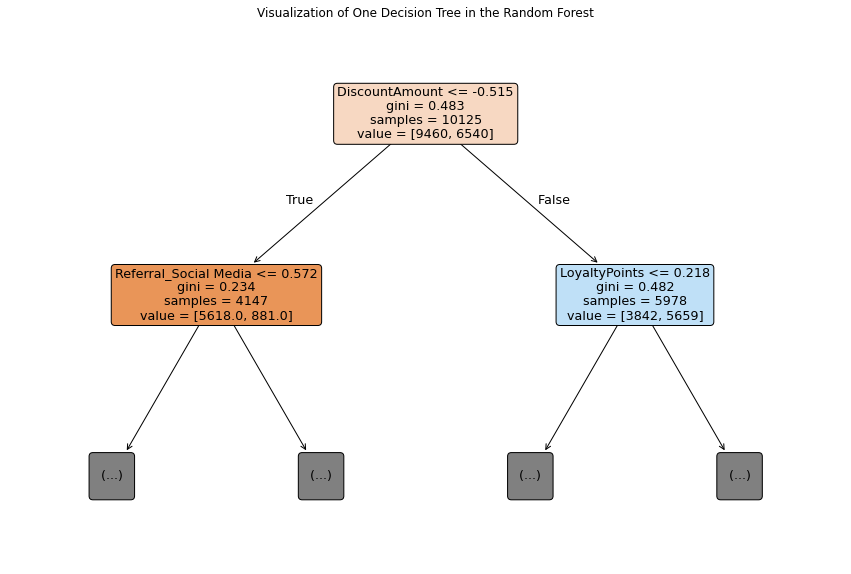

In [486]:
from sklearn.tree import plot_tree

# Visualize one tree in the forest
plt.figure(figsize=(15, 10))
plot_tree(model.estimators_[0], feature_names=X.columns, filled=True, rounded=True, max_depth=1)
plt.title("Visualization of One Decision Tree in the Random Forest")
plt.show()

Our model takes a subject and first assesses its metrics with the root node shown in the middle. The root node classifies the the subject to be either true in holding all expected values or false in this aspect, sending it to a new node to have its metreic assessed again. 

This process of iterating through multiple different trees trained on existing purchase data narrows down our guess of whether a subject is a buyer or not. As previously stated, our data is very well suited for this style of classification model, explaining our high scores in our prediction evaluation. 

Below we have an extended version of the random forest tree exemplifying its thouroughness, and beside it a graph of feature importance in our tree model. The feature importance chart highlights which variable hold more weight in deciphering the classsification of a subject. High importance features like Number of Pages Viewed, Discount Amount, and Loyalty Points will typically be main metric measures in the nodes of our tree.

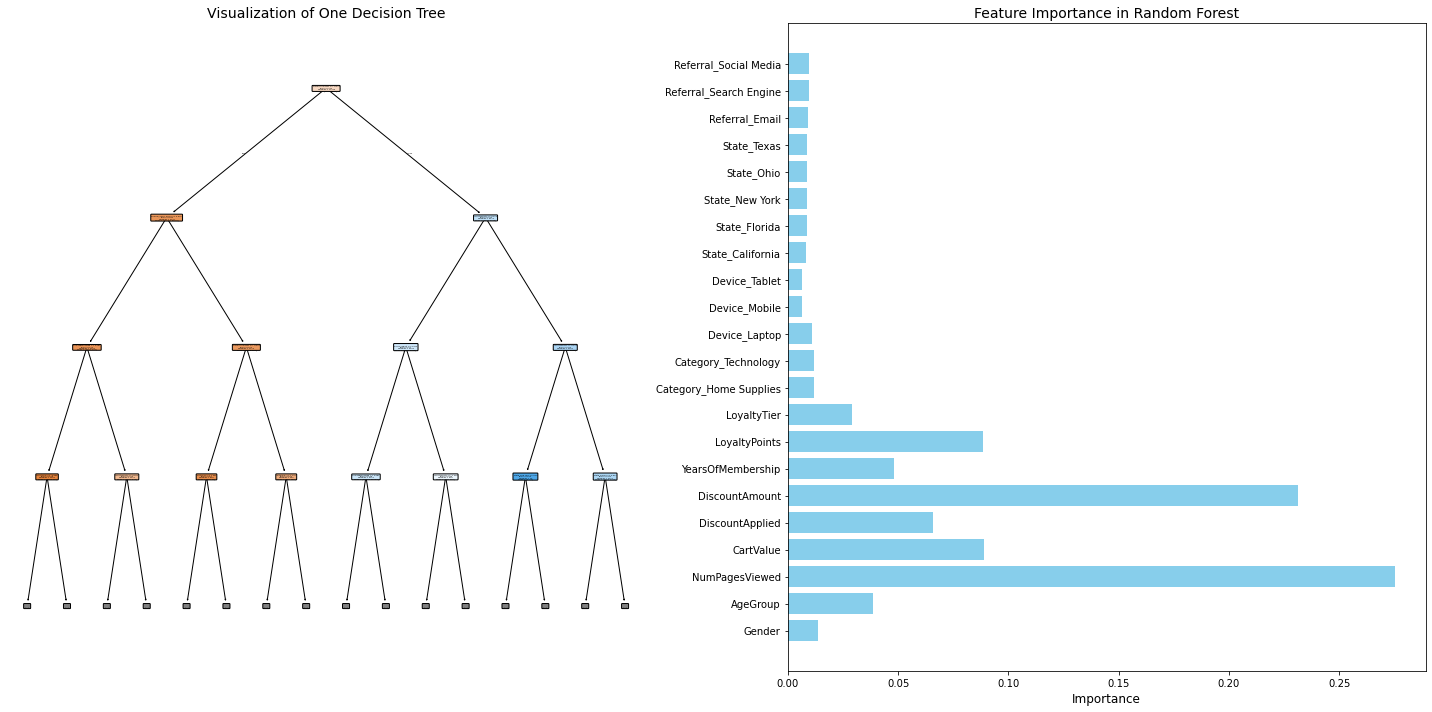

In [488]:
# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))  # 1 row, 2 columns

# Plot the Decision Tree on the left
plot_tree(model.estimators_[0], feature_names=X.columns, filled=True, rounded=True, max_depth=3, ax=axes[0])
axes[0].set_title("Visualization of One Decision Tree", fontsize=14)

# Plot Feature Importance on the right
importances = model.feature_importances_
features = X.columns
axes[1].barh(features, importances, color='skyblue')
axes[1].set_xlabel('Importance', fontsize=12)
axes[1].set_title('Feature Importance in Random Forest', fontsize=14)

# Adjust layout and display
plt.tight_layout()
plt.show()

# 4) Conclusion

After analyzing both the Logistic Regression and Random Forest models, it is clear that the Random Forest outperforms Logistic Regression in terms of accuracy and its ability to handle both the majority and minority classes effectively. Logistic Regression achieved an accuracy of 77%, with noticeable difficulty in predicting the minority class, as indicated by a lower F1-score of 0.71 for class 1.0. In contrast, the Random Forest model reached an improved accuracy of 85%, with higher F1-scores for both classes (0.88 for class 0.0 and 0.81 for class 1.0), demonstrating better overall performance and balance.

Additionally, cross-validation results reinforced these findings, with the Random Forest maintaining an average accuracy of 84.8% compared to 77.1% for Logistic Regression. This suggests that Random Forest not only generalizes better but also captures complex patterns in the data that Logistic Regression, a linear model, may miss. 


A random forest model outperforms logistic regression due to its ability to capture complex relationships between features and outcomes. Since a random forest combines multiple decision trees, it can better handle correlations between variables and provide greater accuracy. This makes random forests a powerful choice for businesses seeking to maximize predictive performance, understand deeper customer behavior trends, and a more suitable choice for this classification task.